# Driving14x14WideRoundAbout-n2-v0 KLR Experiment analysis

In [1]:
import copy
import os.path as osp
from typing import List, Any, Optional, Tuple, Callable
from itertools import permutations, product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import posggym_agents

import baposgmcp.plot as plot_utils
import baposgmcp.plot.paper as paper_utils
from baposgmcp.config import BASE_REPO_DIR

baposgmcp_results_file = osp.join(
    BASE_REPO_DIR, "experiments", "Driving", "Driving14x14WideRoundAbout-n2-v0", "results", "klr_experiment_results_v1.csv"
)
figure_dir = osp.join(BASE_REPO_DIR, "experiments", "Driving", "Driving14x14WideRoundAbout-n2-v0", "figures")
policy_results_file = osp.join(
    posggym_agents.config.BASE_DIR, 'agents', "driving14x14wideroundabout_n2_v0", "results", "klrbr_results.csv"
)

## Define Co-Player Prior

In [2]:
# Uniform
# Note K4 is not in prior 
policy_prior = {1: {
    'klr_k0_seed0-v0': 0.25,
    'klr_k1_seed0-v0': 0.25,
    'klr_k2_seed0-v0': 0.25,
    'klr_k3_seed0-v0': 0.25,
}}
coplayer_policy_ids = list(policy_prior[1])
print(coplayer_policy_ids)

['klr_k0_seed0-v0', 'klr_k1_seed0-v0', 'klr_k2_seed0-v0', 'klr_k3_seed0-v0']


# Problem size

**States**

```
= (pos x dir x speed x destination x destination_reached x crashed x min_dist_goal)^2 
# -1 since agents can't have same pos or dest
= (104 * 4 * 4 * 4 * 2 * 2 * 26) * (103 * 4 * 4 * 3 * 2 * 2 * 26)    
= 355,924,967,424
```

**Actions** = 5 (do_nothing, accelerate, decelerate,  turn_right, turn_left)

**Observations** = 3 cells in front, 1 to each side, 1 behind = 5x3 grid

## The Environment

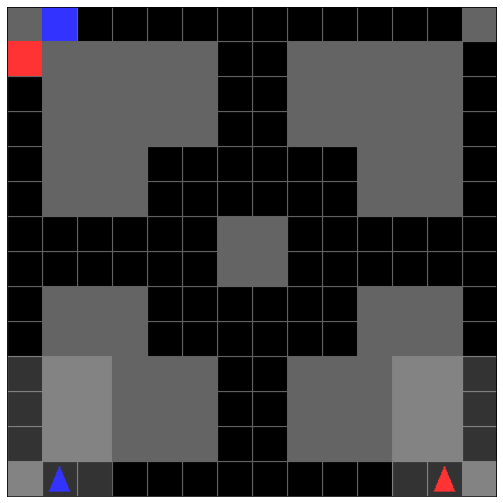

In [4]:
fig, ax = plot_utils.plot_environment("Driving14x14WideRoundAbout-n2-v0", (9, 9))
fig.savefig(osp.join(figure_dir, "Driving_env.png"))
plt.show()

## Loading Heuristic Policy Data

In [5]:
policy_df = plot_utils.import_results(
    policy_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)
policy_df.columns

all_fixed_policy_ids = policy_df["policy_id"].unique().tolist()
all_fixed_policy_ids.sort()
print(all_fixed_policy_ids)

['klr_k0_seed0-v0', 'klr_k0_seed1-v0', 'klr_k0_seed2-v0', 'klr_k0_seed3-v0', 'klr_k0_seed4-v0', 'klr_k1_seed0-v0', 'klr_k1_seed1-v0', 'klr_k1_seed2-v0', 'klr_k1_seed3-v0', 'klr_k1_seed4-v0', 'klr_k2_seed0-v0', 'klr_k2_seed1-v0', 'klr_k2_seed2-v0', 'klr_k2_seed3-v0', 'klr_k2_seed4-v0', 'klr_k3_seed0-v0', 'klr_k3_seed1-v0', 'klr_k3_seed2-v0', 'klr_k3_seed3-v0', 'klr_k3_seed4-v0', 'klr_k4_seed0-v0', 'klr_k4_seed1-v0', 'klr_k4_seed2-v0', 'klr_k4_seed3-v0', 'klr_k4_seed4-v0', 'klrbr_k4_seed0-v0', 'klrbr_k4_seed1-v0', 'klrbr_k4_seed2-v0', 'klrbr_k4_seed3-v0', 'klrbr_k4_seed4-v0', 'uniform_random-v0']


## Loading BAPOSGMCP Data

In [6]:
baposgmcp_df = plot_utils.import_results(
    baposgmcp_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)
policy_ids = baposgmcp_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in baposgmcp_df.columns:
    print("  ", f'"{c}",')

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/utils.py:114: DtypeWarning: Columns (8,9,10,13,14,16,17,18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(result_file)


Policies
--------
   POMetaRollout_greedy_numsims1000_actionselectionpucb_truncatedFalse
   POMetaRollout_greedy_numsims1000_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_numsims1000_actionselectionucb_truncatedFalse
   POMetaRollout_greedy_numsims1000_actionselectionucb_truncatedTrue
   POMetaRollout_greedy_numsims1000_actionselectionuniform_truncatedFalse
   POMetaRollout_greedy_numsims1000_actionselectionuniform_truncatedTrue
   POMetaRollout_greedy_numsims100_actionselectionpucb_truncatedFalse
   POMetaRollout_greedy_numsims100_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_numsims100_actionselectionucb_truncatedFalse
   POMetaRollout_greedy_numsims100_actionselectionucb_truncatedTrue
   POMetaRollout_greedy_numsims100_actionselectionuniform_truncatedFalse
   POMetaRollout_greedy_numsims100_actionselectionuniform_truncatedTrue
   POMetaRollout_greedy_numsims10_actionselectionpucb_truncatedFalse
   POMetaRollout_greedy_numsims10_actionselectionpucb_truncatedTr

In [7]:
# Drop unneeded co-player policies
policies_to_keep = policy_ids + ["klr_k4_seed0-v0"]
policy_df = policy_df[policy_df["policy_id"].isin(policies_to_keep)]
fixed_policy_ids = policy_df["policy_id"].unique().tolist()
fixed_policy_ids.sort()
print(fixed_policy_ids)

['klr_k0_seed0-v0', 'klr_k1_seed0-v0', 'klr_k2_seed0-v0', 'klr_k3_seed0-v0', 'klr_k4_seed0-v0']


## Heuristic policies pairwise performance

This is what was used to generate the meta-policies.

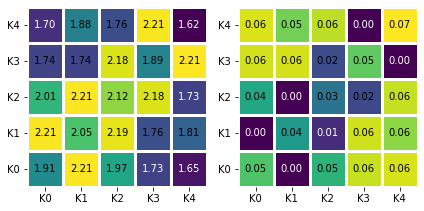

In [9]:
fig, axs = plot_utils.plot_pairwise_comparison(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(6, 3), 
    valfmt="{x:.2f}",
    policies=fixed_policy_ids,
    coplayer_policies=fixed_policy_ids,
    policy_labels={
        "klr_k0_seed0-v0": "K0",
        "klr_k1_seed0-v0": "K1",
        "klr_k2_seed0-v0": "K2",
        "klr_k3_seed0-v0": "K3",
        "klr_k4_seed0-v0": "K4"
    },
    average_duplicates=True,
    duplicate_warning=False
)
fig.savefig(osp.join(figure_dir, "Driving14x14WideRoundAbout-n2-v0_policy_payoff.png"))

## Add Full-Knowledge Best-Response baseline

In [10]:
best_response_map = {
    "klr_k0_seed0-v0": "klr_k1_seed0-v0",
    "klr_k1_seed0-v0": "klr_k2_seed0-v0",
    "klr_k2_seed0-v0": "klr_k3_seed0-v0",
    "klr_k3_seed0-v0": "klr_k4_seed0-v0",
    # FYI K4 is added but is not used in expected results, 
    # since K4 not in other policy prior
    "klr_k4_seed0-v0": "klr_k3_seed0-v0",
}

new_rows = []
for coplayer_policy_id, br_policy_id in best_response_map.items():
    next_exp_id = policy_df["exp_id"].max() + 1
    br_row = policy_df.loc[
        # use results from agent 0 so it's the same as BA-POSGMCP and other baseline results
        (policy_df["agent_id"] == 0)
        & (policy_df["policy_id"] == br_policy_id) 
        & (policy_df["coplayer_policy_id"] == coplayer_policy_id)
    ].copy()
    br_coplayer_row = policy_df.loc[
        (policy_df["agent_id"] == 1)
        & (policy_df["exp_id"].isin(br_row["exp_id"]))
    ].copy()
    # update policy id to baseline name
    br_row["policy_id"] = "full-knowledge-br"
    # update exp ids to avoid duplicates
    br_row["exp_id"] = next_exp_id
    br_coplayer_row["exp_id"] = next_exp_id
    new_rows.append(br_row)
    new_rows.append(br_coplayer_row)

print(len(new_rows))
br_df = pd.concat(new_rows, axis='rows').reset_index(drop=True)
print(len(br_df))
policy_br_df = pd.concat([policy_df, br_df], ignore_index=True)

print(len(policy_br_df))
policy_br_df[policy_br_df["policy_id"] == "full-knowledge-br"]
    

10
10
220


Unnamed: 0  exp_id  agent_id                          env_name  exp_seed  \
210         428     238         0  Driving14x14WideRoundAbout-n2-v0         0   
212         660     238         0  Driving14x14WideRoundAbout-n2-v0         0   
214         844     238         0  Driving14x14WideRoundAbout-n2-v0         0   
216        1060     238         0  Driving14x14WideRoundAbout-n2-v0         0   
218         868     238         0  Driving14x14WideRoundAbout-n2-v0         0   

     num_episodes     policy_name          policy_id  policy_seed  K  ...  \
210          1000  PPOPolicy_pi_1  full-knowledge-br            0  1  ...   
212          1000  PPOPolicy_pi_2  full-knowledge-br            0  2  ...   
214          1000  PPOPolicy_pi_3  full-knowledge-br            0  3  ...   
216          1000  PPOPolicy_pi_4  full-knowledge-br            0  4  ...   
218          1000  PPOPolicy_pi_3  full-knowledge-br            0  3  ...   

    num_NA  episode_return_CI  episode_steps_CI  episode_time_CI  prop_LOSS  \
210      0           0.004321          0.116152         0.038302      0.000   
212      0           0.004393          0.217854         0.036358      0.000   
214      0           0.018489          0.133130         0.039960      0.011   
216      0           0.004246          0.102640         0.043274      0.000   
218      0           0.004319          0.104956         0.043259      0.000   

     prop_DRAW  prop_WIN  prop_NA  num_sims  coplayer_policy_id  
210        0.0     1.000      0.0         0     klr_k0_seed0-v0  
212        0.0     1.000      0.0         0     klr_k1_seed0-v0  
214        0.0     0.989      0.0         0     klr_k2_seed0-v0  
216        0.0     1.000      0.0         0     klr_k3_seed0-v0  
218        0.0     1.000      0.0         0     klr_k4_seed0-v0  

[5 rows x 33 columns]

## Combine data

In [11]:
# First need to update exp_ids of one dataframe so there are no duplicate exp_ids
df1 = baposgmcp_df
df2 = policy_br_df

df1_max_exp_id = df1["exp_id"].max()
if df2["exp_id"].min() <= df1_max_exp_id:
    df2["exp_id"] += df1_max_exp_id+1

combined_df = pd.concat([df1, df2]).reset_index(drop = True)

def add_alg_id(row):
    pi_id = row["policy_id"]
    if pi_id.startswith("klr"):
        return "fixed"
    tokens = pi_id.split("_")
    alg_id = "_".join([
        t for t in tokens 
        if all(
            s not in t for s in [
                "actionselection", "numsims", "truncated", "greedy", "softmax", "uniform", "piklr"
            ]
        )
    ])
    return alg_id


def add_meta_pi(row):
    pi_id = row["policy_id"]
    for meta_pi in ["greedy", "softmax", "uniform"]:
        if meta_pi in pi_id:
            return meta_pi
    return "NA"


combined_df["alg_id"] = combined_df.apply(add_alg_id, axis=1)
combined_df["meta_pi"] = combined_df.apply(add_meta_pi, axis=1)
    
policy_ids = combined_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)
    
alg_ids = combined_df["alg_id"].unique().tolist()
alg_ids.sort()
print("\nAlg IDs")
print("-------")
for n in alg_ids:
    print("  ", n)
    
print("\nMeta Pis:")
print("---------")
print(combined_df["meta_pi"].unique().tolist())

print("\nColumns")
print("-------")
for c in combined_df.columns:
    print("  ", c)

Policies
--------
   POMetaRollout_greedy_numsims1000_actionselectionpucb_truncatedFalse
   POMetaRollout_greedy_numsims1000_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_numsims1000_actionselectionucb_truncatedFalse
   POMetaRollout_greedy_numsims1000_actionselectionucb_truncatedTrue
   POMetaRollout_greedy_numsims1000_actionselectionuniform_truncatedFalse
   POMetaRollout_greedy_numsims1000_actionselectionuniform_truncatedTrue
   POMetaRollout_greedy_numsims100_actionselectionpucb_truncatedFalse
   POMetaRollout_greedy_numsims100_actionselectionpucb_truncatedTrue
   POMetaRollout_greedy_numsims100_actionselectionucb_truncatedFalse
   POMetaRollout_greedy_numsims100_actionselectionucb_truncatedTrue
   POMetaRollout_greedy_numsims100_actionselectionuniform_truncatedFalse
   POMetaRollout_greedy_numsims100_actionselectionuniform_truncatedTrue
   POMetaRollout_greedy_numsims10_actionselectionpucb_truncatedFalse
   POMetaRollout_greedy_numsims10_actionselectionpucb_truncatedTr

## Pairwise performance

Here we look at the performance of each policy against each other policy including BAPOSGMCP and baselines with different number of simulations, action selection, and meta-policies.

(<Figure size 1440x26568 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

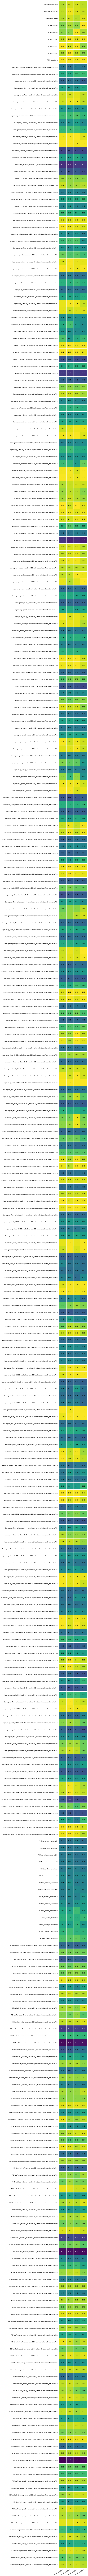

In [28]:
plot_utils.plot_pairwise_comparison(
    combined_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(20, len(combined_df["policy_id"].unique())), 
    valfmt="{x:.2f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

(<Figure size 1440x26568 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

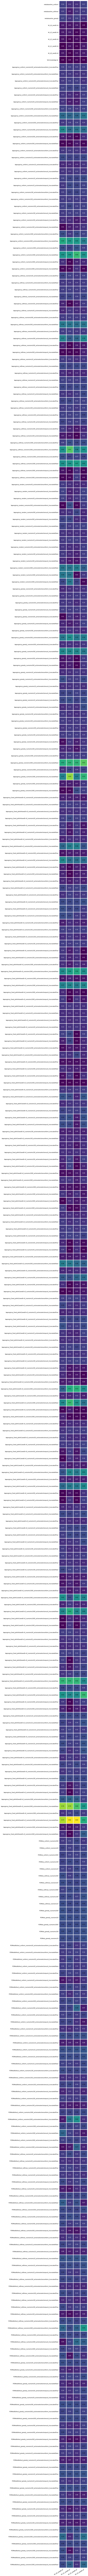

In [29]:
plot_utils.plot_pairwise_comparison(
    combined_df,
    y_key="episode_return_CI", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(20, len(combined_df["policy_id"].unique())), 
    valfmt="{x:.2f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

(<Figure size 1440x26568 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

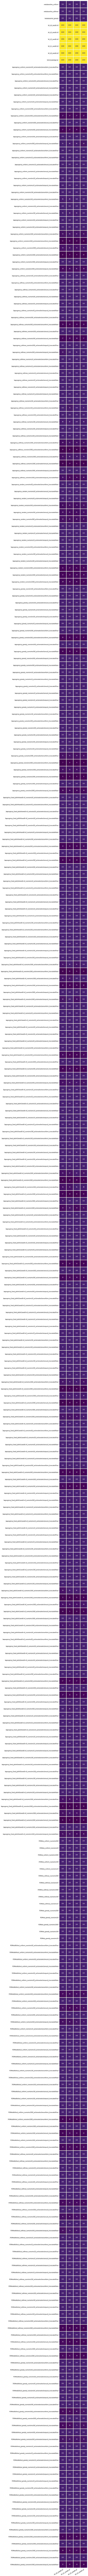

In [30]:
plot_utils.plot_pairwise_comparison(
    combined_df,
    y_key="num_episodes", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(20, len(combined_df["policy_id"].unique())), 
    valfmt="{x:.0f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

## Policy Prior Performance

Here we look at the expected performance against the policy prior of BAPOSGMCP.

In [12]:
exp_df = plot_utils.get_uniform_expected_df(combined_df, policy_prior)

Ungrouped size = 1500
Grouped size = 369


In [18]:
# Base plot kwargs
base_plot_kwargs = paper_utils.get_base_plot_kwargs()
return_plot_kwargs = copy.deepcopy(base_plot_kwargs)
return_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Return",
})

step_plot_kwargs = copy.deepcopy(return_plot_kwargs)
step_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Steps"
})

### Action Selection

In [15]:
exp_df["action_selection"].unique()

array(['pucb', 'ucb', 'uniform', None], dtype=object)

In [16]:
act_sel_alg_group_keys = ["alg_id", "num_sims", "action_selection"]
act_sel_alg_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
for k in act_sel_alg_group_keys:
    if k in act_sel_alg_agg_dict:
        act_sel_alg_agg_dict.pop(k)

act_sel_df = exp_df[
    (exp_df["action_selection"].isin(['pucb', 'ucb', 'uniform']))
    & (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp_fixed", "baposgmcp_random", "POMetaRollout"]))
]
gb = act_sel_df.groupby(act_sel_alg_group_keys)
gb_agg = gb.agg(**act_sel_alg_agg_dict)
act_sel_alg_df = gb_agg.reset_index()
act_sel_alg_df = act_sel_alg_df.astype({"num_sims": int})

act_sel_alg_df.sort_values(by=["alg_id", "action_selection", "num_sims"], inplace=True)

print("Ungrouped size =", len(act_sel_df))
print("Grouped size =", len(act_sel_alg_df))

act_sel_alg_ids = act_sel_alg_df["alg_id"].unique()
act_sel_alg_ids.sort()

Ungrouped size = 345
Grouped size = 60


POMetaRollout
baposgmcp
baposgmcp_fixed
baposgmcp_random


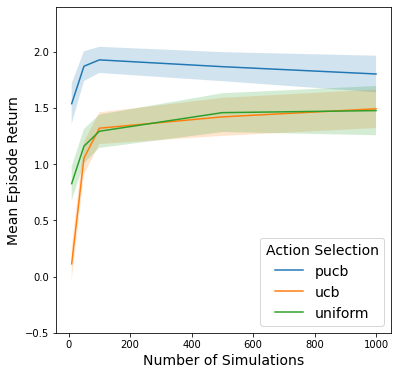

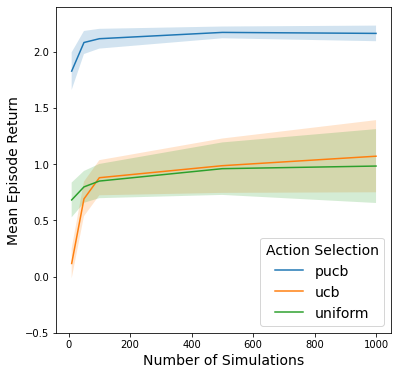

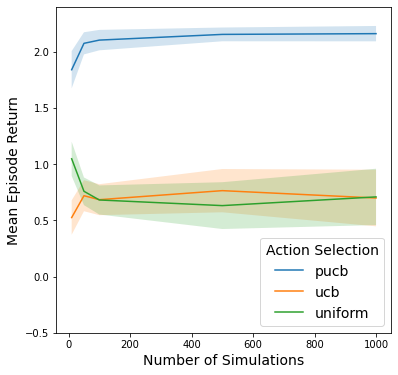

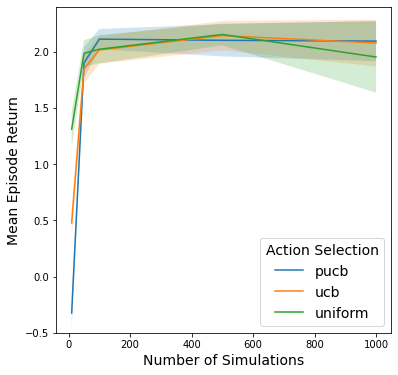

In [19]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (-0.5, 2.4),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    "title": "Action Selection",  
})

for alg_id in act_sel_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_action_selection_vs_num_sims_by_alg(
        act_sel_alg_df[act_sel_alg_df["alg_id"] == alg_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"{alg_id}_act_sel_return_comparison.png"))
    
del plot_kwargs

POMetaRollout
baposgmcp
baposgmcp_fixed
baposgmcp_random


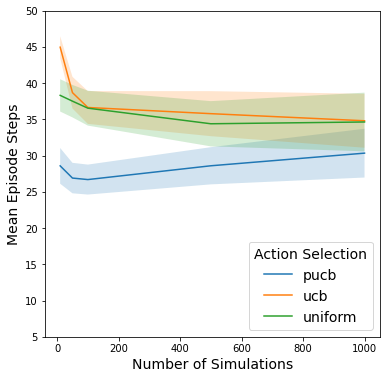

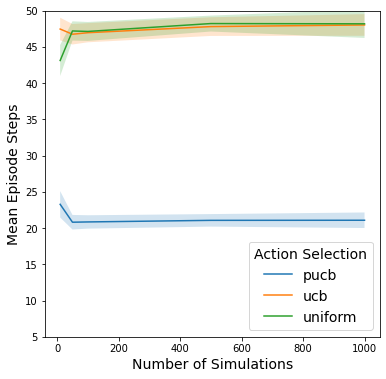

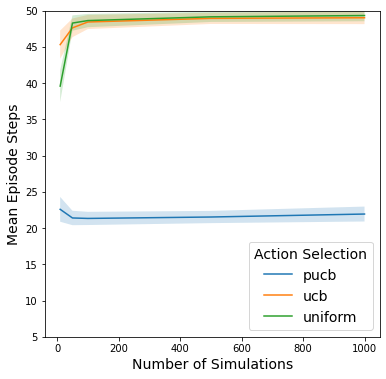

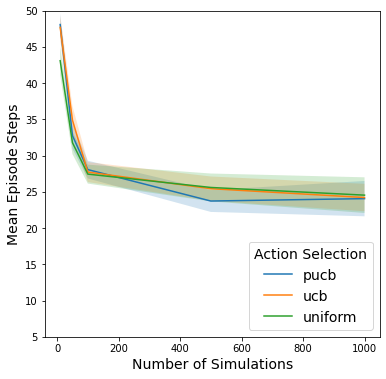

In [26]:
plot_kwargs = copy.deepcopy(step_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (5, 50),
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'lower right',
    "title": "Action Selection",  
})

for alg_id in act_sel_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_action_selection_vs_num_sims_by_alg(
        act_sel_alg_df[act_sel_alg_df["alg_id"] == alg_id],
        y_key="episode_steps_mean",
        y_err_key="episode_steps_CI",
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"{alg_id}_act_sel_steps_comparison.png"))
    
del plot_kwargs

## Comparison of truncation

In [27]:
trunc_df = exp_df[
    (exp_df["action_selection"].isin(['pucb']))
    & (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp_fixed", "POMetaRollout"]))
]

def clean_truncated(row):
    v = row["truncated"] 
    if v == "True":
        return True
    if v == "False":
        return False
    assert isinstance(v, bool)
    return v

trunc_df["truncated"] = trunc_df.apply(clean_truncated, axis=1)
trunc_df = trunc_df.astype({"truncated": bool})
print(trunc_df["truncated"].unique())

# group over meta-policy values
trunc_group_keys = ["alg_id", "num_sims", "truncated"]
trunc_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
for k in trunc_group_keys:
    if k in trunc_agg_dict:
        trunc_agg_dict.pop(k)

gb = trunc_df.groupby(trunc_group_keys)
gb_agg = gb.agg(**trunc_agg_dict)
trunc_gb_df = gb_agg.reset_index()

trunc_gb_df.sort_values(by=["alg_id", "truncated", "num_sims"], inplace=True)

print("Ungrouped size =", len(trunc_df))
print("Grouped size =", len(trunc_gb_df))
print(trunc_gb_df)

trunc_alg_ids = trunc_gb_df["alg_id"].unique()
trunc_alg_ids.sort()

/tmp/ipykernel_25762/914987615.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trunc_df["truncated"] = trunc_df.apply(clean_truncated, axis=1)


[False  True]
Ungrouped size = 110
Grouped size = 30
             alg_id  num_sims  truncated  exp_id  exp_seed coplayer_policy_id  \
0     POMetaRollout        10      False     388         0    klr_k0_seed0-v0   
2     POMetaRollout        50      False     412         0    klr_k0_seed0-v0   
4     POMetaRollout       100      False     436         0    klr_k0_seed0-v0   
6     POMetaRollout       500      False     460         0    klr_k0_seed0-v0   
8     POMetaRollout      1000      False     484         0    klr_k0_seed0-v0   
1     POMetaRollout        10       True     384         0    klr_k0_seed0-v0   
3     POMetaRollout        50       True     408         0    klr_k0_seed0-v0   
5     POMetaRollout       100       True     432         0    klr_k0_seed0-v0   
7     POMetaRollout       500       True     456         0    klr_k0_seed0-v0   
9     POMetaRollout      1000       True     480         0    klr_k0_seed0-v0   
10        baposgmcp        10      False       4        

POMetaRollout
baposgmcp
baposgmcp_fixed


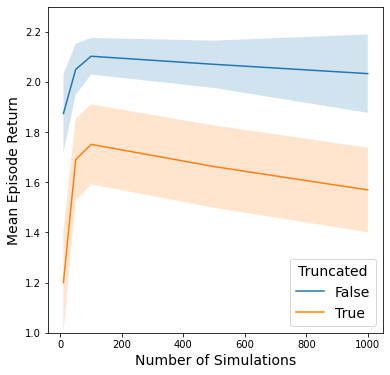

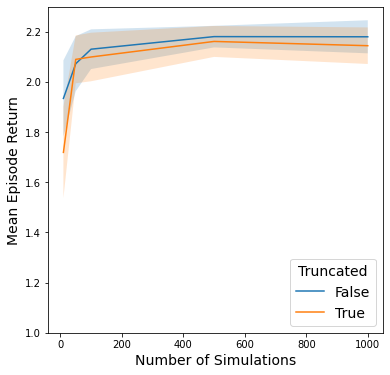

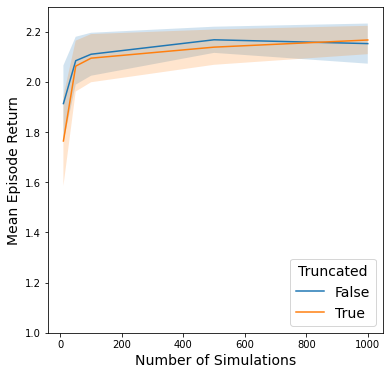

In [28]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (1.0, 2.3),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    "title": "Truncated", 
})

for alg_id in trunc_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        trunc_gb_df[trunc_gb_df["alg_id"] == alg_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"{alg_id}_truncated_return_comparison.png"))
    
del plot_kwargs

POMetaRollout
baposgmcp
baposgmcp_fixed


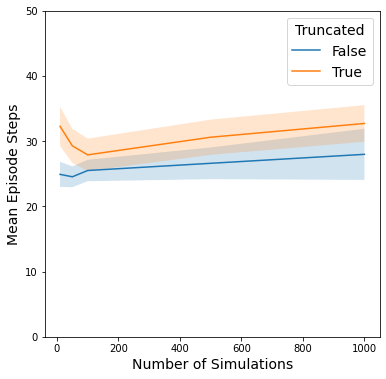

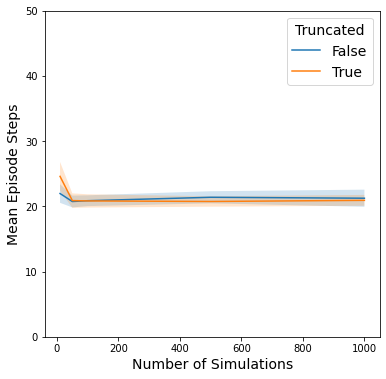

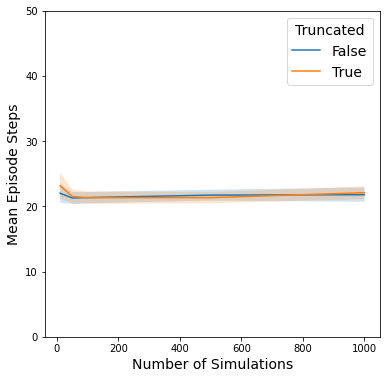

In [30]:
plot_kwargs = copy.deepcopy(step_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (0, 50),
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper right',
    "title": "Truncated",  
})

for alg_id in trunc_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        trunc_gb_df[trunc_gb_df["alg_id"] == alg_id],
        y_key="episode_steps_mean",
        y_err_key="episode_steps_CI",
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"{alg_id}_truncated_step_comparison.png"))
    
del plot_kwargs

POMetaRollout
baposgmcp
baposgmcp_fixed


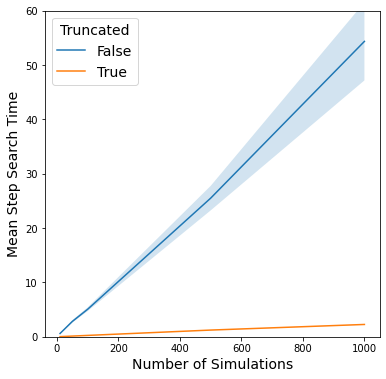

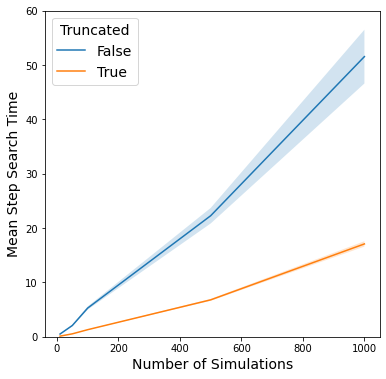

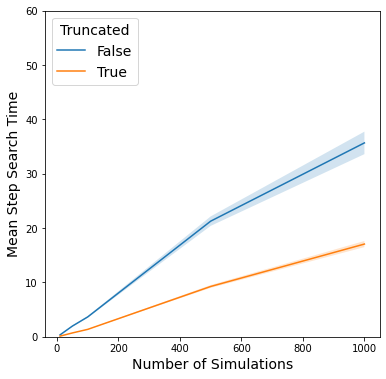

In [35]:
time_plot_kwargs = copy.deepcopy(return_plot_kwargs)
time_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Step Search Time",
    "ylim": (0, 60)
})
time_plot_kwargs["legend_kwargs"].update({
    "loc": 'upper left',
    "title": "Truncated",  
})

for alg_id in trunc_alg_ids:
    print(alg_id)
    fig, _ = paper_utils.plot_multiple_truncated_vs_num_sims_by_alg(
        trunc_gb_df[trunc_gb_df["alg_id"] == alg_id],
        y_key="search_time_mean",
        y_err_key="search_time_CI",
        alg_id_key="alg_id",
        set_title=False,
        **time_plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"{alg_id}_truncated_search_time_comparison.png"))
    
del time_plot_kwargs

## Comparison of the different Meta-Policies

In [39]:
meta_pi_label_map = {
    "greedy": r"$\sigma^{G}$",
    "softmax": r"$\sigma^{S}$",
    "uniform": r"$\sigma^{U}$",
}

meta_pi_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "POMeta", "POMetaRollout", "metabaseline"]))
    & (exp_df["action_selection"].isin(["pucb", None]))
    & (exp_df["truncated"].isin([True, 'True', None]))
]

meta_alg_ids = meta_pi_df["alg_id"].unique().tolist()
meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_alg_ids:
    print(n)
    
policy_ids = meta_pi_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
POMeta
POMetaRollout
baposgmcp
metabaseline

Policy IDs
----------
POMetaRollout_greedy_numsims1000_actionselectionpucb_truncatedTrue
POMetaRollout_greedy_numsims100_actionselectionpucb_truncatedTrue
POMetaRollout_greedy_numsims10_actionselectionpucb_truncatedTrue
POMetaRollout_greedy_numsims500_actionselectionpucb_truncatedTrue
POMetaRollout_greedy_numsims50_actionselectionpucb_truncatedTrue
POMetaRollout_softmax_numsims1000_actionselectionpucb_truncatedTrue
POMetaRollout_softmax_numsims100_actionselectionpucb_truncatedTrue
POMetaRollout_softmax_numsims10_actionselectionpucb_truncatedTrue
POMetaRollout_softmax_numsims500_actionselectionpucb_truncatedTrue
POMetaRollout_softmax_numsims50_actionselectionpucb_truncatedTrue
POMetaRollout_uniform_numsims1000_actionselectionpucb_truncatedTrue
POMetaRollout_uniform_numsims100_actionselectionpucb_truncatedTrue
POMetaRollout_uniform_numsims10_actionselectionpucb_truncatedTrue
POMetaRollout_uniform_numsims500_actionselectionpucb_

POMeta
POMetaRollout
baposgmcp
metabaseline


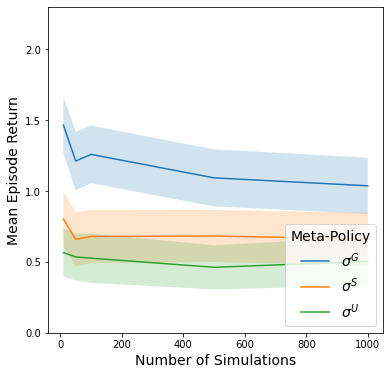

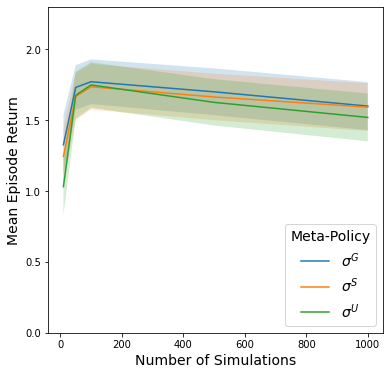

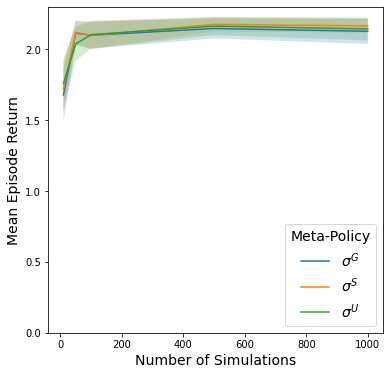

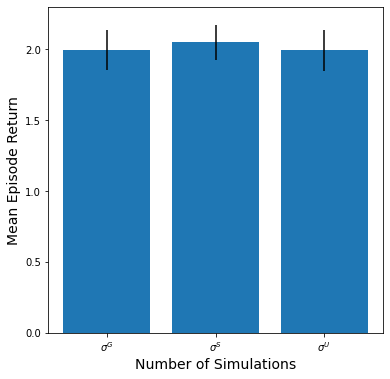

In [41]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (0.0, 2.3),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    "title": "Meta-Policy" 
})

for alg_id in meta_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_meta_policy_vs_num_sims(
        meta_pi_df[meta_pi_df["alg_id"] == alg_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        meta_pi_label_map=meta_pi_label_map,
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"{alg_id}_meta_pi_return_comparison.png"))
    
del plot_kwargs

POMeta
POMetaRollout
baposgmcp
metabaseline


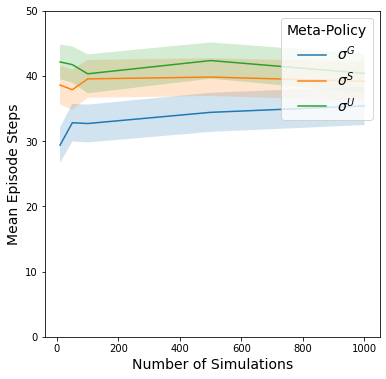

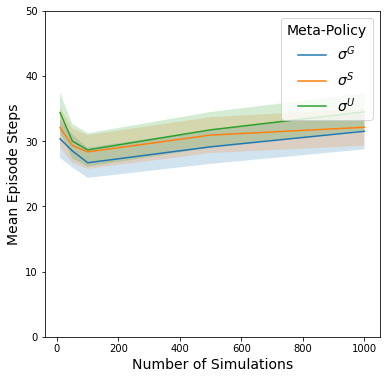

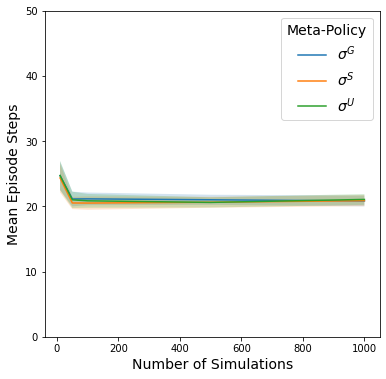

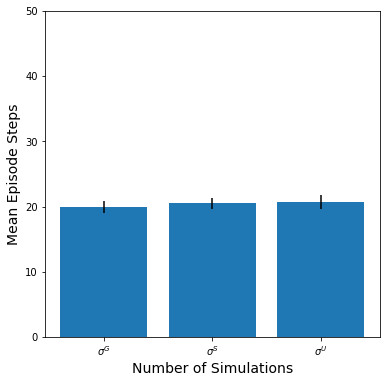

In [57]:
plot_kwargs = copy.deepcopy(step_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (0, 50),
})
plot_kwargs["legend_kwargs"].update({
    "loc": 'upper right',
    "title": "Meta-Policy",  
})

for alg_id in meta_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_meta_policy_vs_num_sims(
        meta_pi_df[meta_pi_df["alg_id"] == alg_id],
        y_key="episode_steps_mean",
        y_err_key="episode_steps_CI",
        meta_pi_label_map=meta_pi_label_map,
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.savefig(osp.join(figure_dir, f"{alg_id}_meta_pi_step_comparison.png"))
    
del plot_kwargs

## Comparing Meta-Policy versus no meta-policy

Here we look at the performance of BAPOSGMCP (using PUCB) with using a meta-policy against not using a meta-policy (i.e. using the different fixed policies).

In [59]:
meta_vs_no_pi_label_map = {
    "baposgmcp_uniform": r"$\sigma^{U}$",
    "baposgmcp_random": "Random",
    "baposgmcp_fixed_piklrk0seed0-v0": "K0", 
    "baposgmcp_fixed_piklrk1seed0-v0": "K1", 
    "baposgmcp_fixed_piklrk2seed0-v0": "K2",
    "baposgmcp_fixed_piklrk3seed0-v0": "K3",
    "baposgmcp_fixed_piklrk4seed0-v0": "K4"
}

# Use DF containing only policies with PUCB action_selection or NA
meta_vs_no_meta_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp_fixed", "baposgmcp_random"]))
    & (exp_df["action_selection"].isin(["pucb"]))
    & (exp_df["meta_pi"].isin(["uniform", "NA"]))
    & (
        (exp_df["alg_id"] == "baposgmcp_random") | (exp_df["truncated"].isin([True, 'True', None]))
    )
]

meta_vs_no_meta_alg_ids = meta_vs_no_meta_df["alg_id"].unique().tolist()
meta_vs_no_meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_vs_no_meta_alg_ids:
    print(n)
    
policy_ids = meta_vs_no_meta_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)
    
fixed_policy_ids = meta_vs_no_meta_df["fixed_policy_id"].unique().tolist()
print("\nFixed Policy IDs")
print("----------------")
for n in fixed_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp_fixed
baposgmcp_random

Policy IDs
----------
baposgmcp_fixed_piklrk0seed0-v0_numsims1000_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk0seed0-v0_numsims100_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk0seed0-v0_numsims10_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk0seed0-v0_numsims500_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk0seed0-v0_numsims50_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk1seed0-v0_numsims1000_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk1seed0-v0_numsims100_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk1seed0-v0_numsims10_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk1seed0-v0_numsims500_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk1seed0-v0_numsims50_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk2seed0-v0_numsims1000_actionselectionpucb_truncatedTrue
baposgmcp_fixed_piklrk2seed0-v0_numsims100_actionselectionpucb_truncated

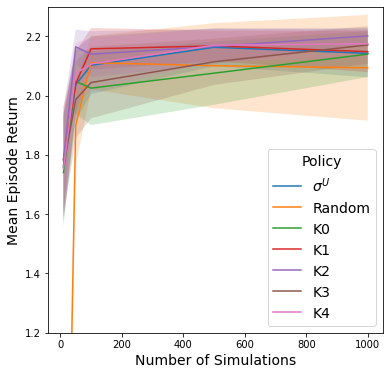

In [64]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (1.2, 2.3),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    "title": "Policy" 
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    meta_vs_no_meta_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[list(meta_vs_no_pi_label_map)],
    pi_label_map=meta_vs_no_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, f"meta_vs_no_return_comparison.png"))
    
del plot_kwargs

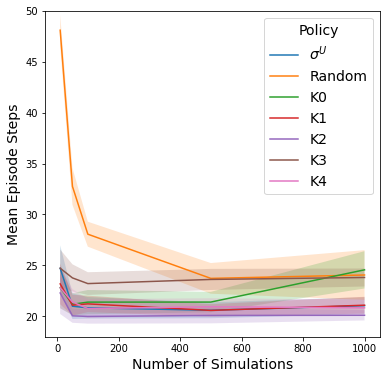

In [66]:
plot_kwargs = copy.deepcopy(step_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (18, 50),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "upper right",
    "title": "Policy" 
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    meta_vs_no_meta_df,
    y_key="episode_steps_mean",
    y_err_key="episode_steps_CI",
    policy_prefixes=[list(meta_vs_no_pi_label_map)],
    pi_label_map=meta_vs_no_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, f"meta_vs_no_steps_comparison.png"))
    
del plot_kwargs

## Comparing BAPOSGMCP versus baselines

In [68]:
perf_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "POMeta", "POMetaRollout", "metabaseline", "full-knowledge-br"]))
    & (exp_df["action_selection"].isin(["pucb", None]))
    & (exp_df["truncated"].isin([True, 'True', None]))
]

policy_prefixes_to_plot = [
    "baposgmcp_uniform",
    "POMeta_greedy",
    "POMetaRollout_greedy",
    "metabaseline_greedy",
    "full-knowledge-br"
]

baseline_pi_label_map = {
    "baposgmcp_uniform": "BAPOSGMCP",
    "baposgmcp_random": "BAPOSGMCP Random",
    "POMeta_softmax": "POMeta", 
    "POMetaRollout_greedy": "POMetaRollout", 
    "metabaseline_greedy": "Meta-Policy",
    "full-knowledge-br": "Best-Response"
}

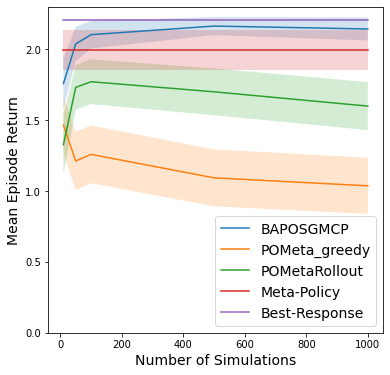

In [69]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (0.0, 2.3),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
})

fig, _ = plot_utils.paper.plot_multiple_performance_vs_num_sims(
    perf_df,
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    **plot_kwargs,
)

fig.savefig(osp.join(figure_dir, "vs_baselines_return_comparison.png"))
    
del plot_kwargs

# Old Stuff

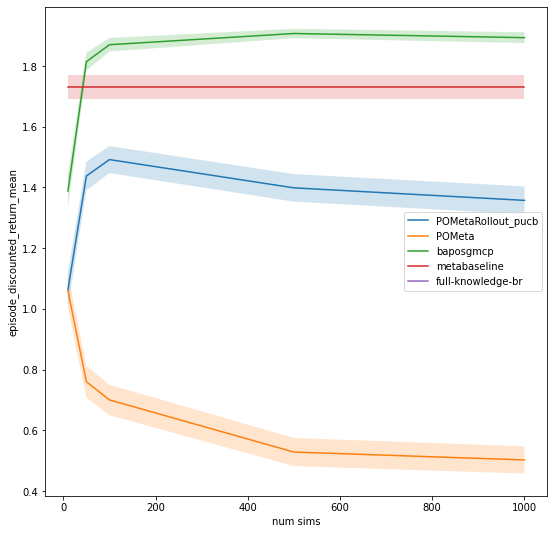

In [82]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="episode_discounted_return_mean",
    y_err_key="episode_discounted_return_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

## Looking at time

   - episode_steps
   - search_time
   - update_time
   - reinvigoration_time
   - policy_calls
   - inference_time
   - search_depth

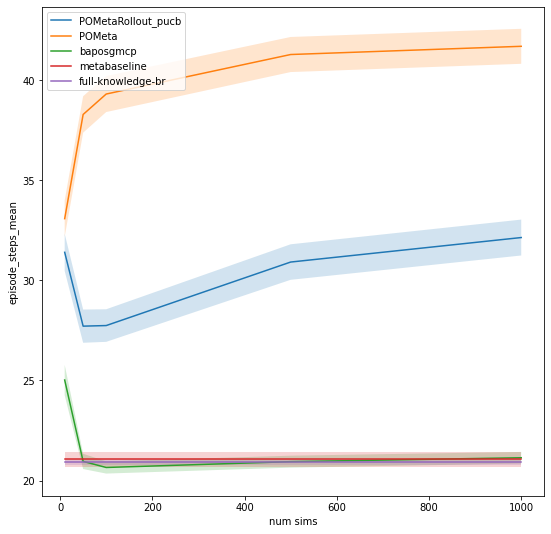

In [84]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="episode_steps_mean",
    y_err_key="episode_steps_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

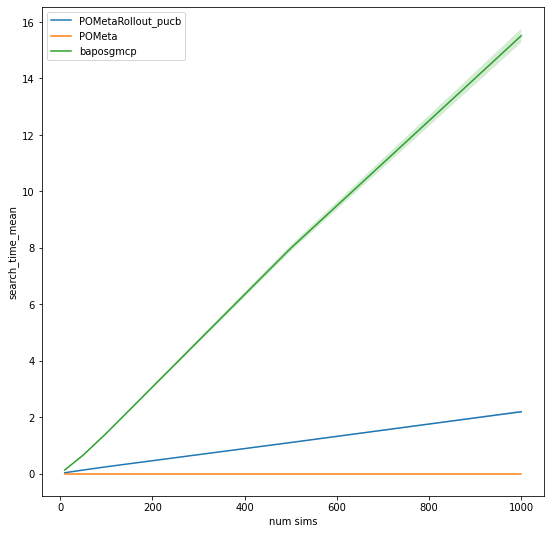

In [35]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="search_time_mean",
    y_err_key="search_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=[]
)

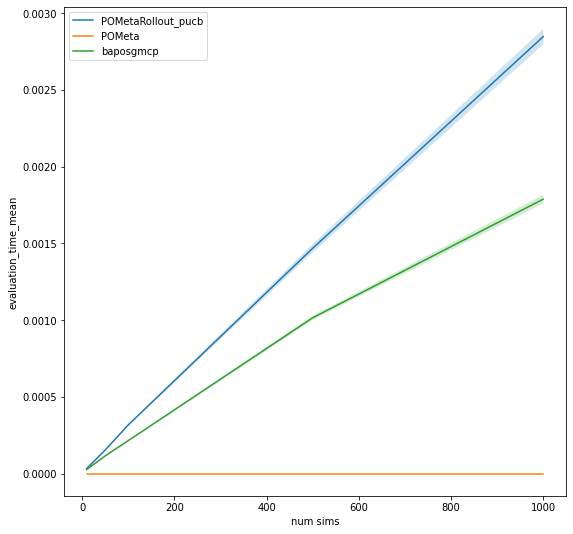

In [36]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="evaluation_time_mean",
    y_err_key="evaluation_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=[]
)

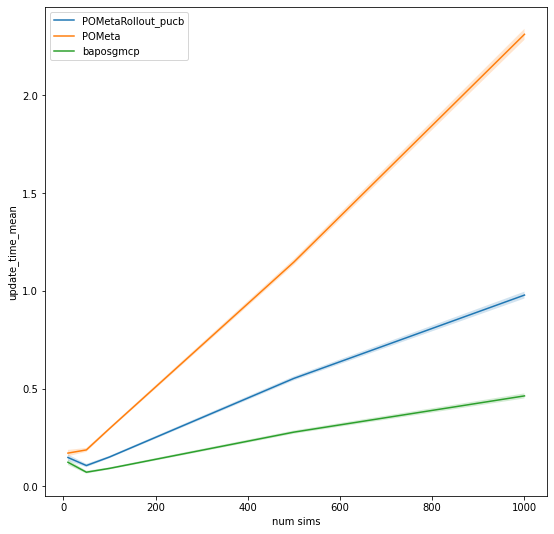

In [37]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="update_time_mean",
    y_err_key="update_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=[]
)

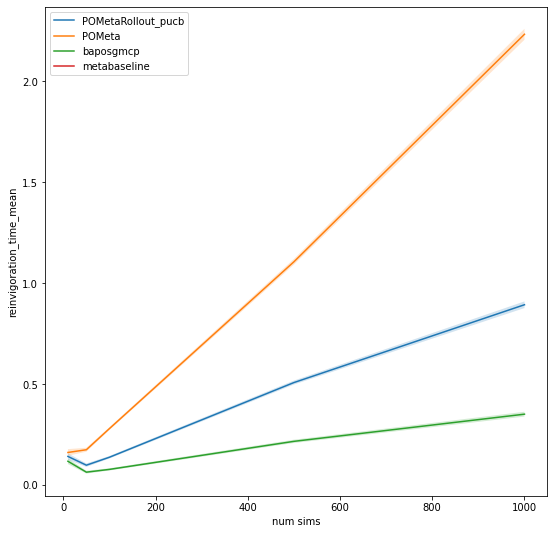

In [38]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="reinvigoration_time_mean",
    y_err_key="reinvigoration_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

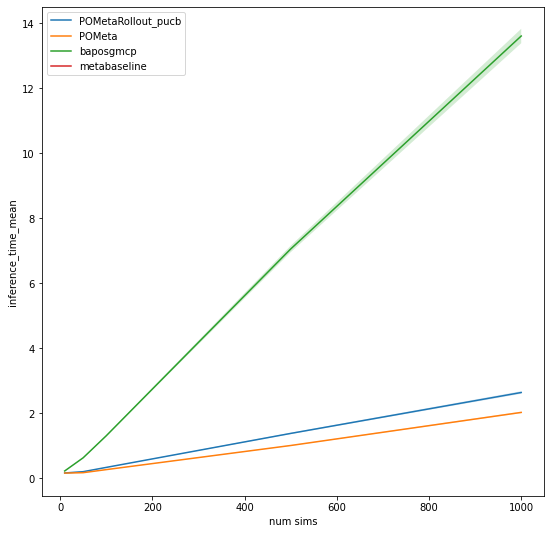

In [39]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="inference_time_mean",
    y_err_key="inference_time_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

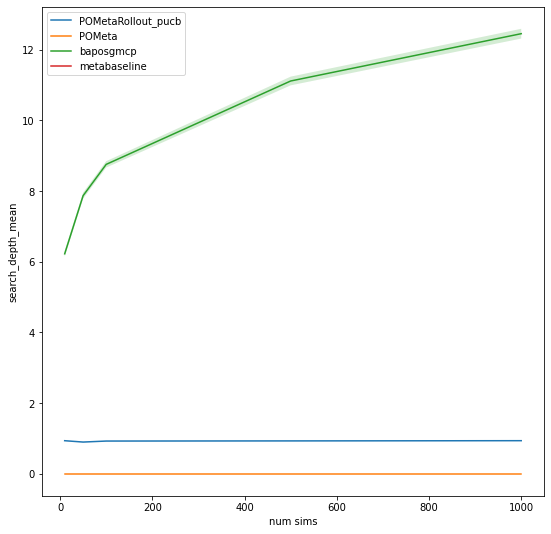

In [40]:
plot_utils.get_and_plot_expected_values_by_num_sims(
    combined_df,
    y_key="search_depth_mean",
    y_err_key="search_depth_CI",
    policy_key="policy_id",
    policy_prior=policy_prior,
    policies_with_sims=policies_with_sims,
    policies_without_sims=policies_without_sims
)

## Looking at Belief accuracy by steps

- action_dist_distance
- bayes_accuracy

In [41]:
policy_ids_by_alg = [
    ["baposgmcp_10", "baposgmcp_50", "baposgmcp_100", "baposgmcp_500", "baposgmcp_1000"],
]

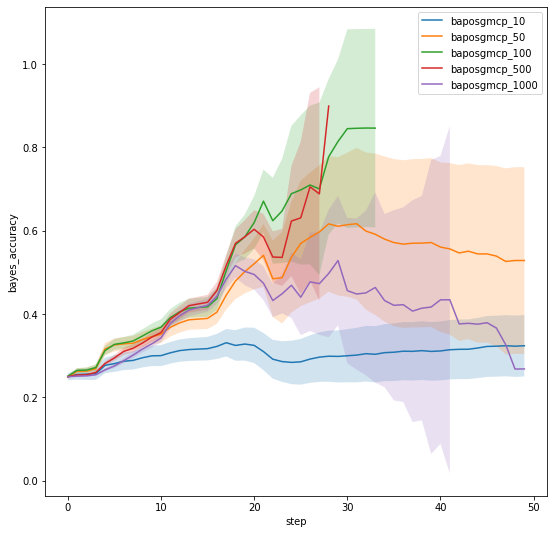

In [42]:
plot_utils.plot_expected_belief_stat_by_step(
    combined_df,
    y_key_prefix="bayes_accuracy",
    policy_ids=policy_ids_by_alg,
    policy_prior=policy_prior,
    step_limit=50,
    other_agent_id=1,
    policy_key="policy_id",
    coplayer_policy_key="coplayer_policy_id",
    y_suffix="mean",
    y_err_suffix="CI",
    figsize=(9, 9)
)

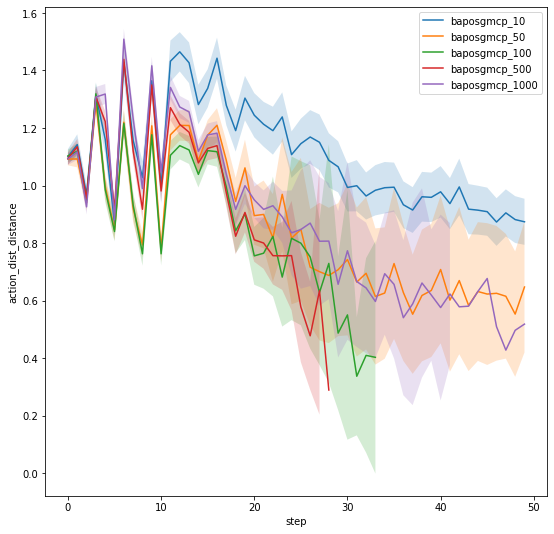

In [43]:
plot_utils.plot_expected_belief_stat_by_step(
    combined_df,
    y_key_prefix="action_dist_distance",
    policy_ids=policy_ids_by_alg,
    policy_prior=policy_prior,
    step_limit=50,
    other_agent_id=1,
    policy_key="policy_id",
    coplayer_policy_key="coplayer_policy_id",
    y_suffix="mean",
    y_err_suffix="CI",
    figsize=(9, 9)
)